# NOTEBOOK 2: ENTRENAMIENTO, VALIDACIÓN Y EXPLOTACIÓN DE MODELOS

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Segundo Notebook: Carga de DataFrames guardados (con inyección en globals)
# Directorio donde se encuentran los .parquet generados en el Notebook 1
BASE_DIR = 'series_filtradas'

def load_all_series(base_dir: str = BASE_DIR):
    """
    1) Recorre todos los .parquet en base_dir.

    2) Inyecta en globals() los DataFrames generales:
         df_Noel_ITS, df_Noel_LTS, df_Varma_ITS, df_Varma_LTS

    3) Construye y devuelve dos dicts con los DataFrames por horizonte:
         noel_ddff: {'df_Noel_ITS_h1': ..., ...}
         varma_ddff: {'df_Varma_ITS_h1', ..., ...}

    4) Además, inyecta también cada uno de estos horizon-specific dataframes
       como variables global, para que aparezcan en el explorador de variables.
    """
    Noel_ddff = {}
    Varma_ddff = {}
    
    for fname in os.listdir(base_dir):
        if not fname.endswith('.parquet'):
            continue
        key = fname[:-8] # quita la extensión '.parquet'
        df = pd.read_parquet(os.path.join(base_dir, fname))

        # DataFrames generales
        if key in ('df_Noel_ITS', 'df_Noel_LTS', 'df_Varma_ITS', 'df_Varma_LTS'):
            globals()[key] = df
        # DataFrames por horizonte
        elif key.startswith('df_Noel_'):
            Noel_ddff[key] = df
            globals()[key] = df
        elif key.startswith('df_Varma_'):
            Varma_ddff[key] = df
            globals()[key] = df
    return Noel_ddff, Varma_ddff

# Ejecutamos la carga
Noel_ddff, Varma_ddff = load_all_series()

# Verificación rápida
print('DataFrames generales cargados en globals():', 
    [k for k in globals() if k in ('df_Noel_ITS', 'df_Noel_LTS', 'df_Varma_ITS', 'df_Varma_LTS')])
print('\nDataFrames de horizonte para Noel:', list(Noel_ddff.keys()))
print('DataFrames de horizonte para Varma:',  list(Varma_ddff.keys()))

DataFrames generales cargados en globals(): ['df_Noel_ITS', 'df_Noel_LTS', 'df_Varma_ITS', 'df_Varma_LTS']

DataFrames de horizonte para Noel: ['df_Noel_ITS_h1', 'df_Noel_ITS_h12', 'df_Noel_ITS_h3', 'df_Noel_ITS_h6', 'df_Noel_ITS_h9', 'df_Noel_LTS_h1', 'df_Noel_LTS_h12', 'df_Noel_LTS_h3', 'df_Noel_LTS_h6', 'df_Noel_LTS_h9']
DataFrames de horizonte para Varma: ['df_Varma_ITS_h1', 'df_Varma_ITS_h3', 'df_Varma_ITS_h6', 'df_Varma_ITS_h9', 'df_Varma_LTS_h1', 'df_Varma_LTS_h3', 'df_Varma_LTS_h6', 'df_Varma_LTS_h9', 'df_Varma_STS_h1', 'df_Varma_STS_h3']


Con esta versión, tras llamar a `load_all_series()`, tendremos en el espacio de trabajo **tanto** los dataframes generales:

- `df_Noel_ITS`
- `df_Noel_LTS`
- `df_Varma_ITS`
- `df_Varma_LTS`

**como** cada uno de los dataframes de horizonte (`df_Noel_ITS_h1`, `df_Noel_ITS_h3`, ..., `df_Varma_LTS_h12`) disponibles como variables independientes.

---

## Visualización de Series por Horizonte

A continuación, se genera un gráfico para cada uno de los DataFrames específicos de horizonte (`df_*_h1`, `df_*_h3`, …).
Cada gráfico muestra **todas las series** que componen ese subconjunto, permitiendo:
   - Observar la dispersión y variabilidad de las series en ese horizonte.
   - Identificar tendencias comunes o patrones estacionales.
   - Comprobar visualmente la densidad de datos y posibles anomalías.

**Detalles de la implementación**  
1. Convierte el DataFrame “apilado” a formato ancho (`pivot`), de modo que cada columna sea una `unique_id`.  
2. Traza todas las series con baja opacidad para evitar saturar la gráfica.  
3. Formatea el eje horizontal para mostrar ticks trimestrales (enero, abril, julio, octubre), facilitando la lectura temporal.  
4. Añade título y etiquetas que incluyen el nombre del DataFrame y el número de series.  

In [3]:
# Aquí se inserta el bloque de procesamiento sobre all_horizon_dfs
# 3) Combinar todos los DataFrames horizon-specific
all_horizon_ddff = {}
all_horizon_ddff.update(Noel_ddff)
all_horizon_ddff.update(Varma_ddff)

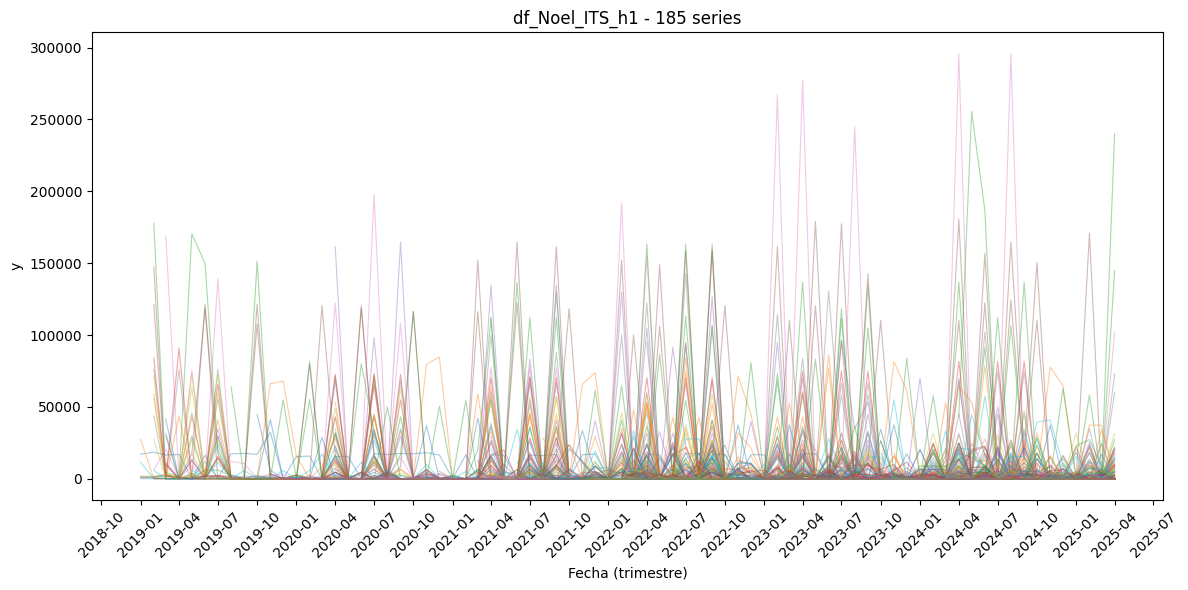

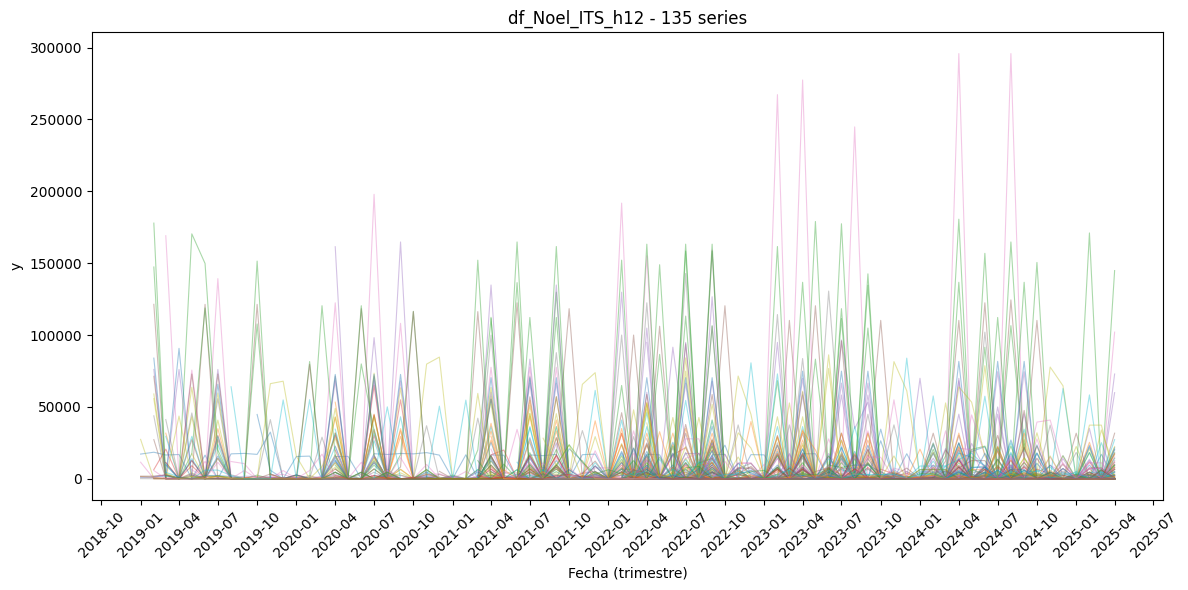

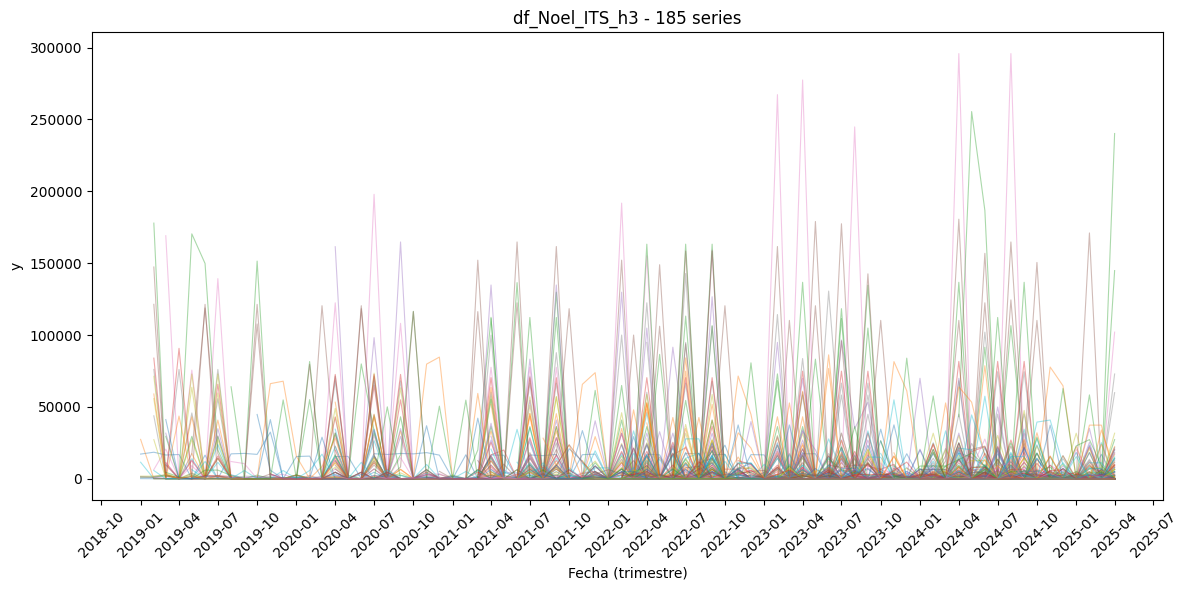

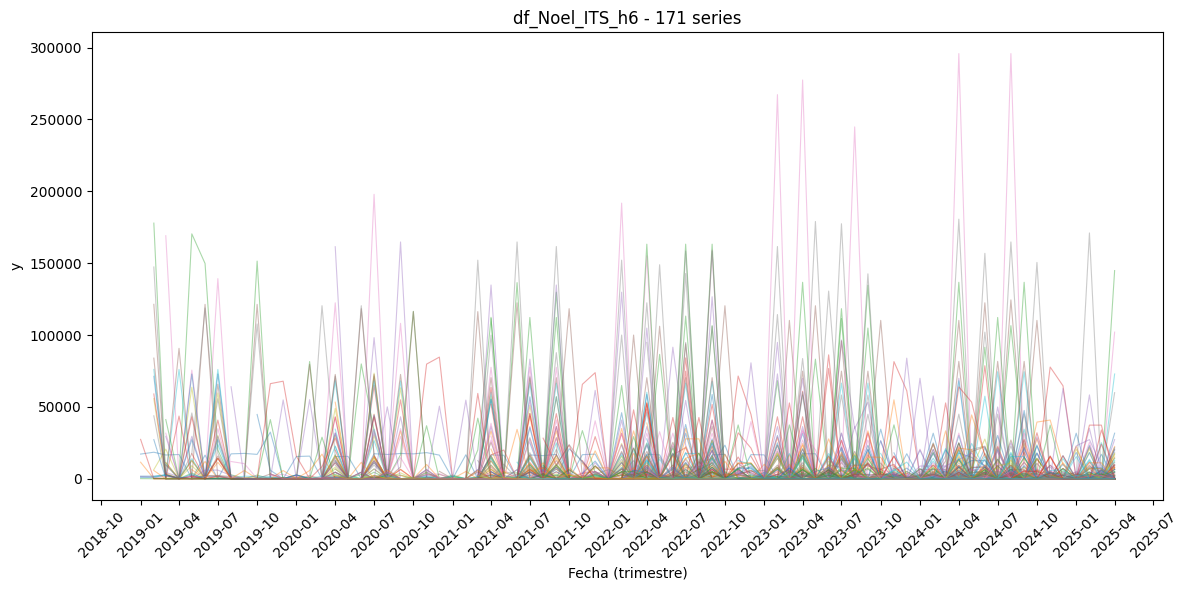

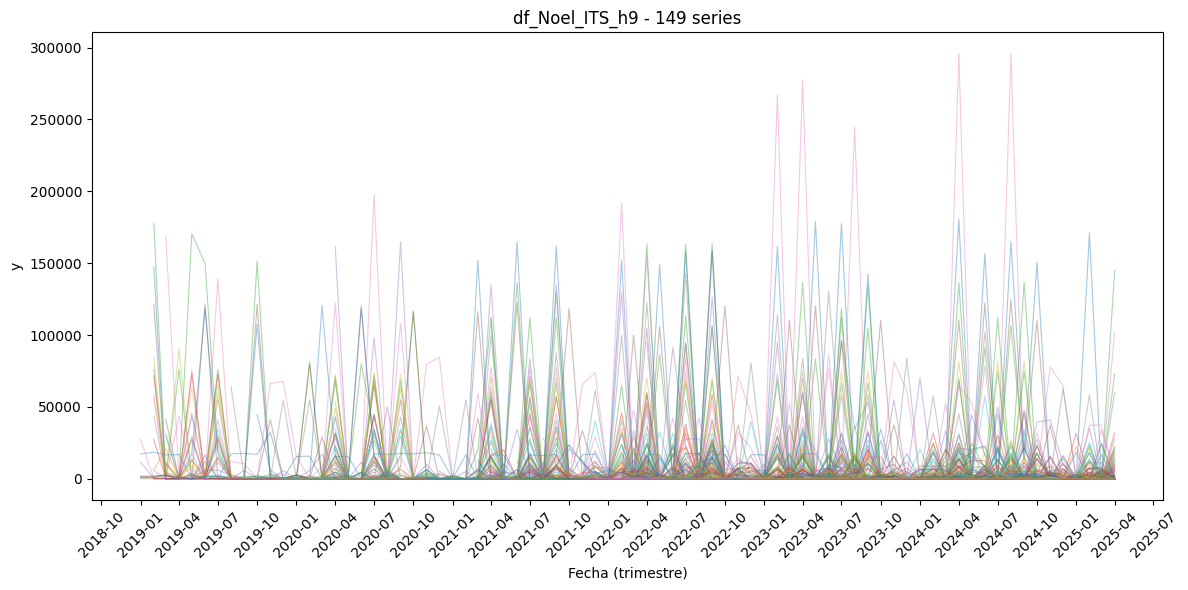

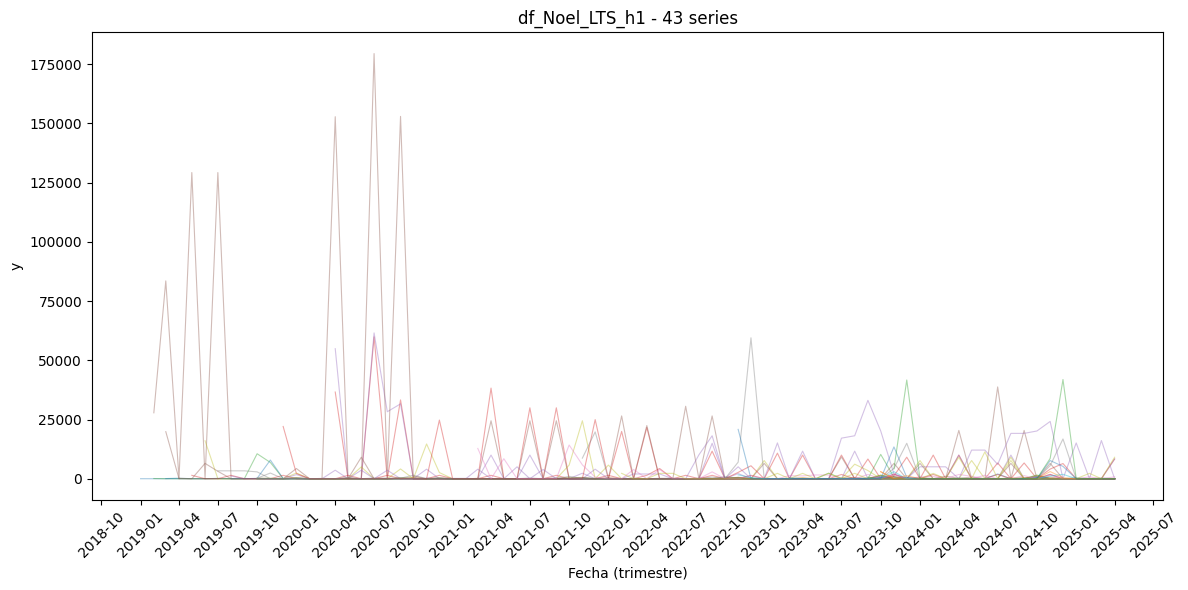

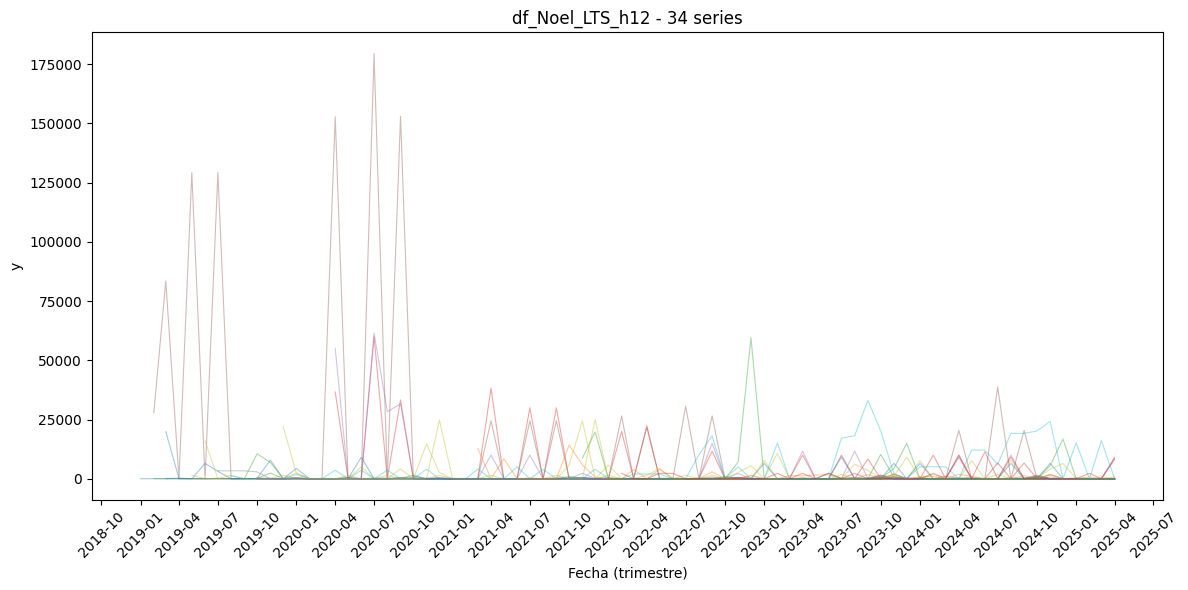

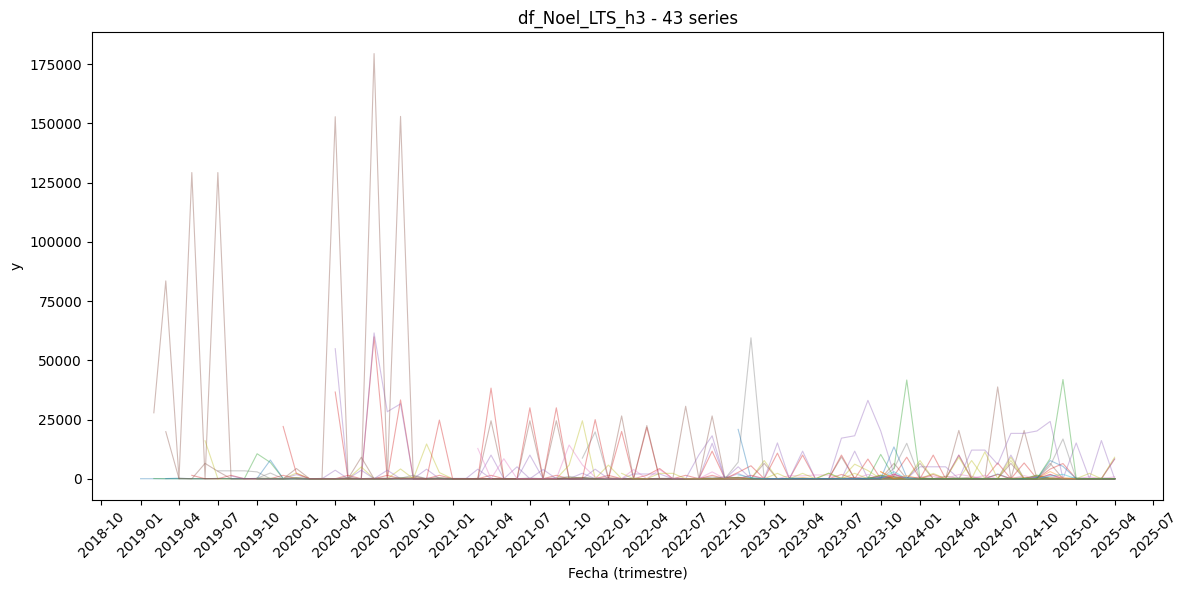

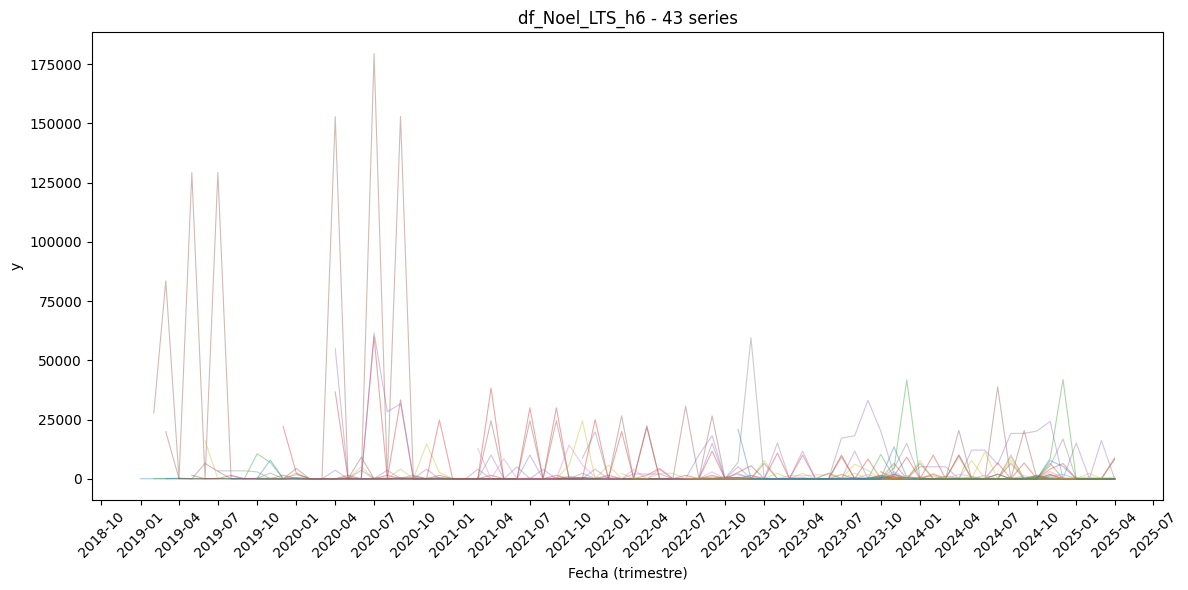

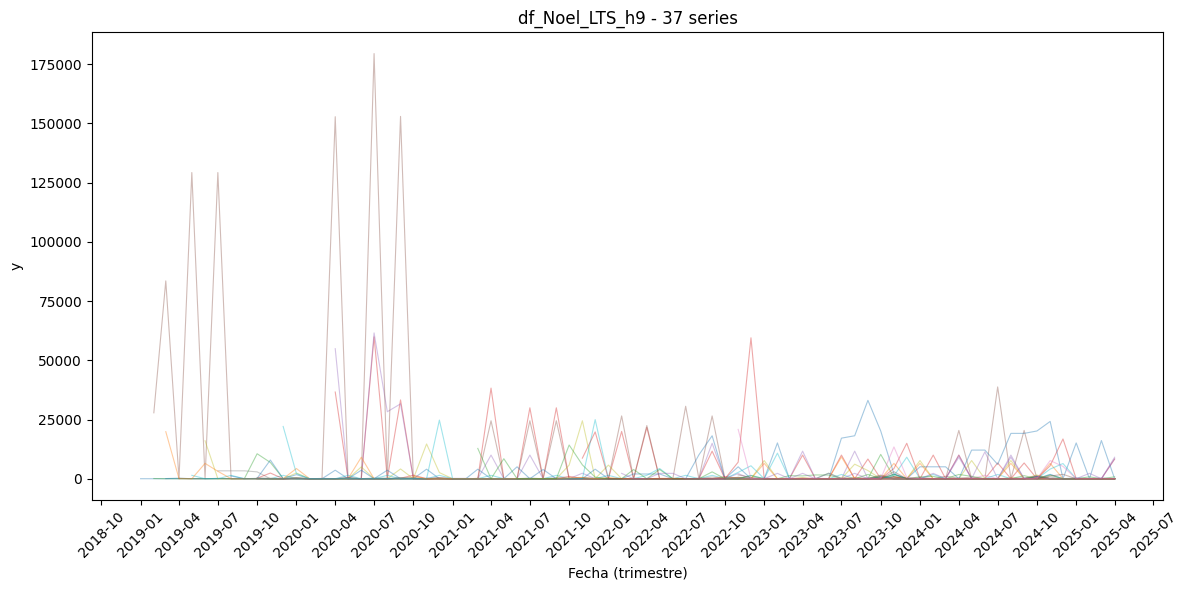

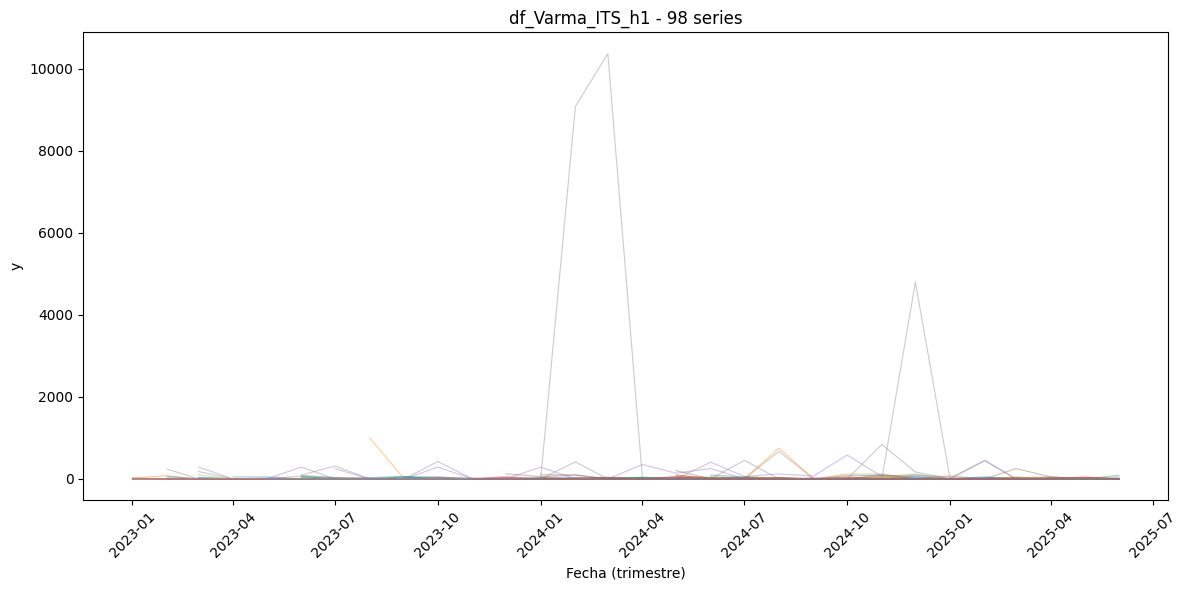

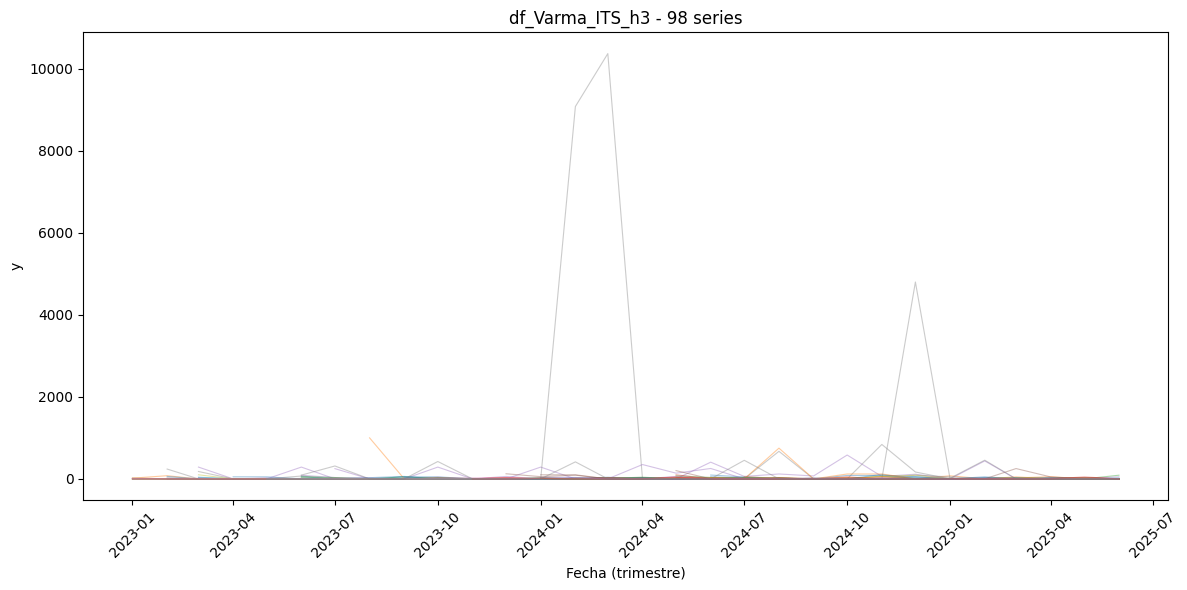

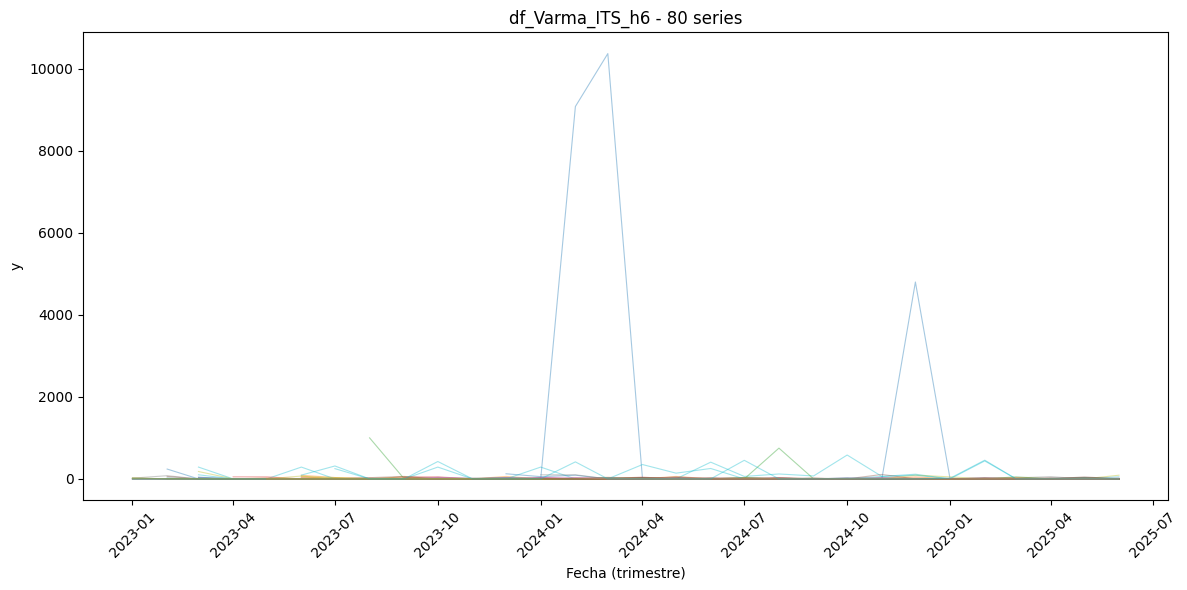

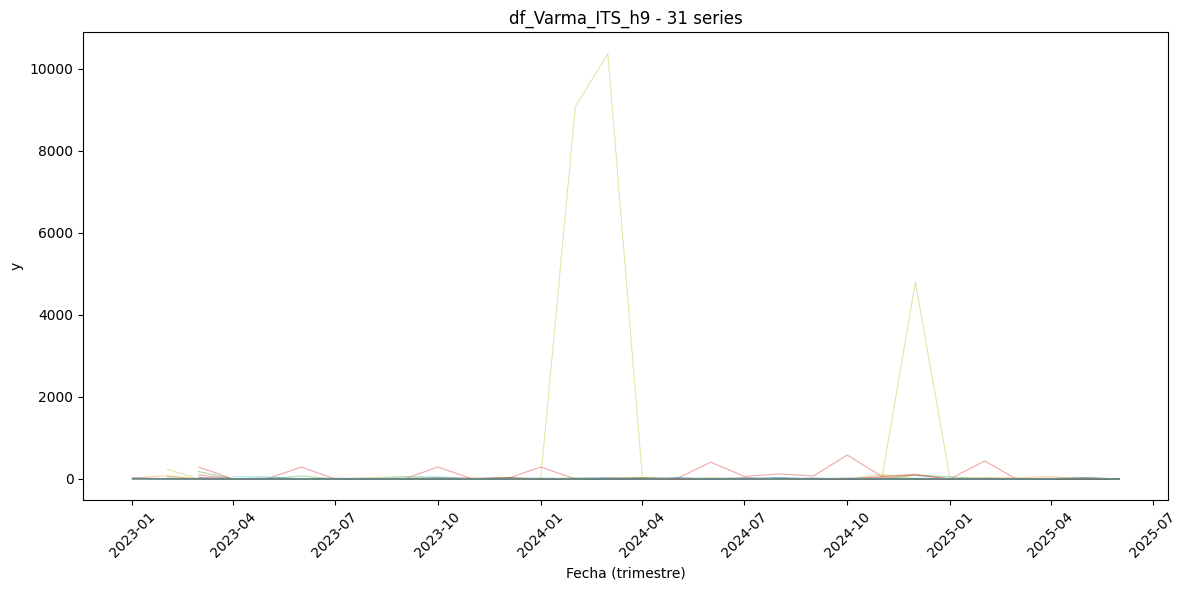

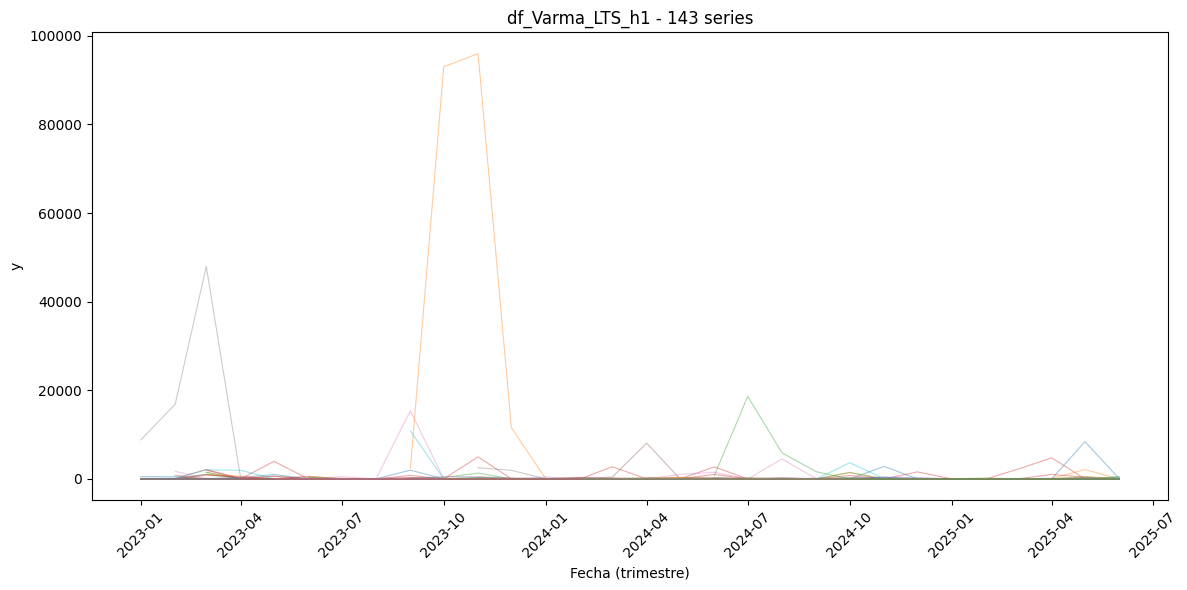

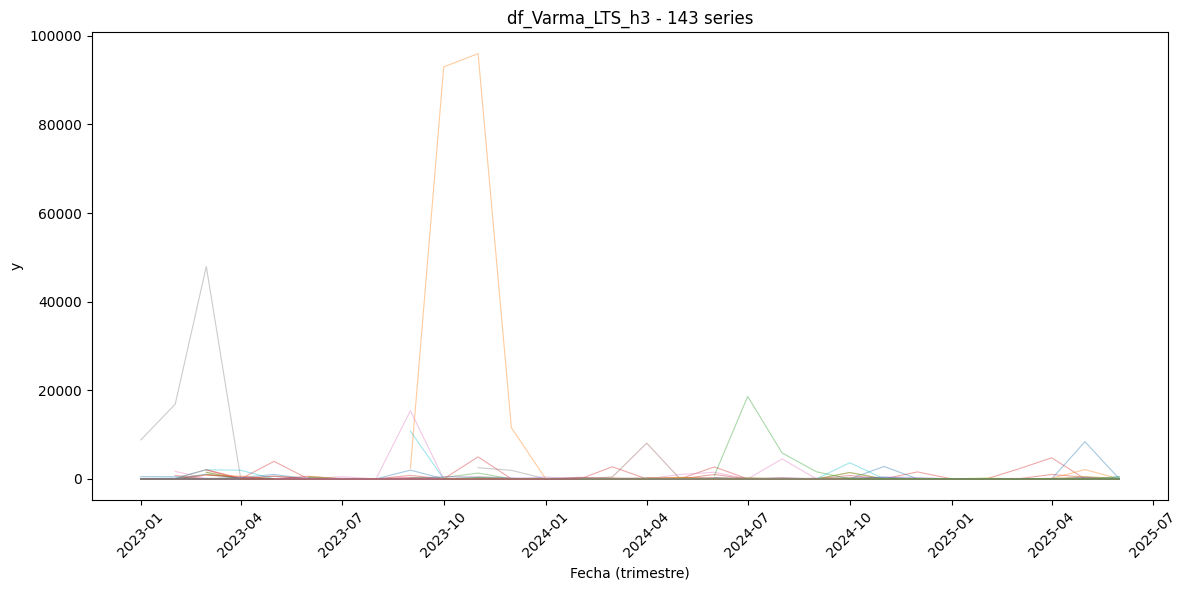

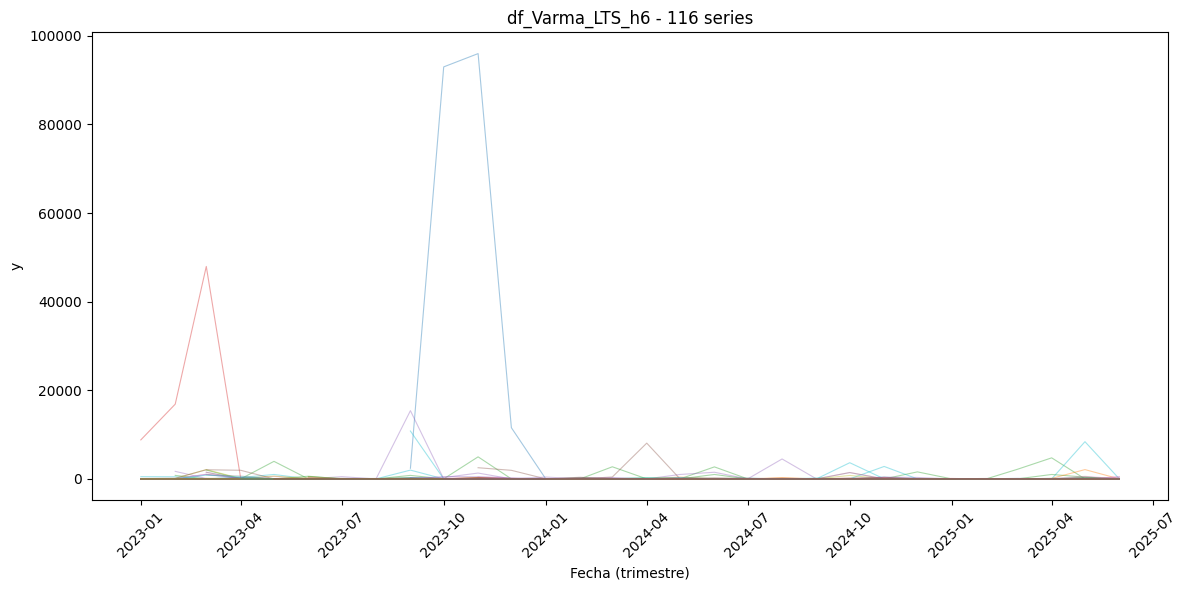

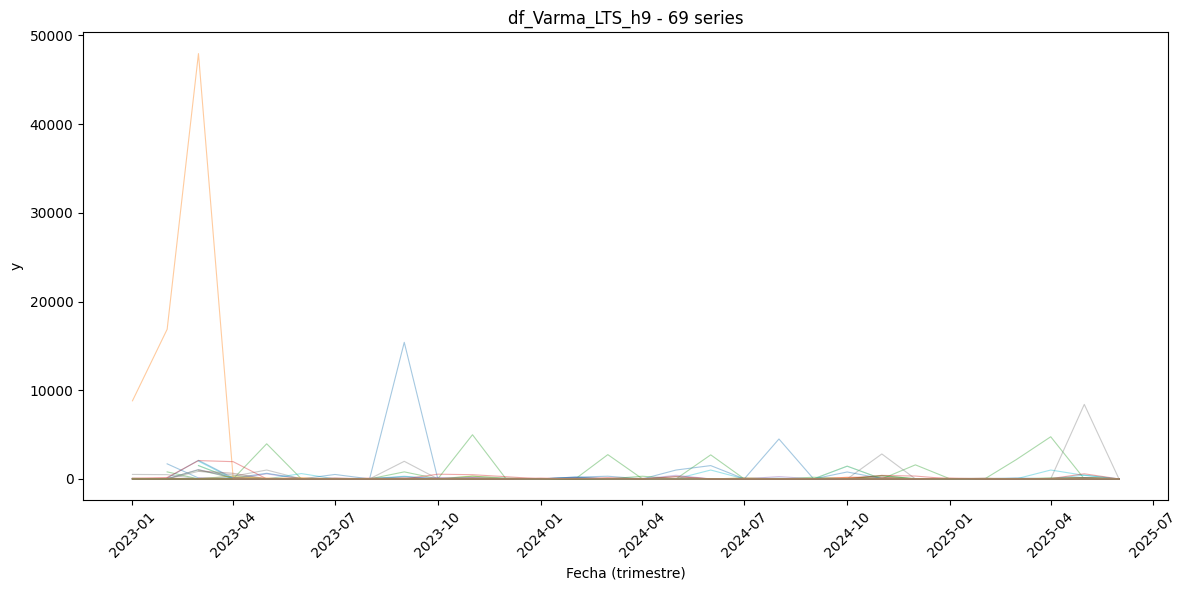

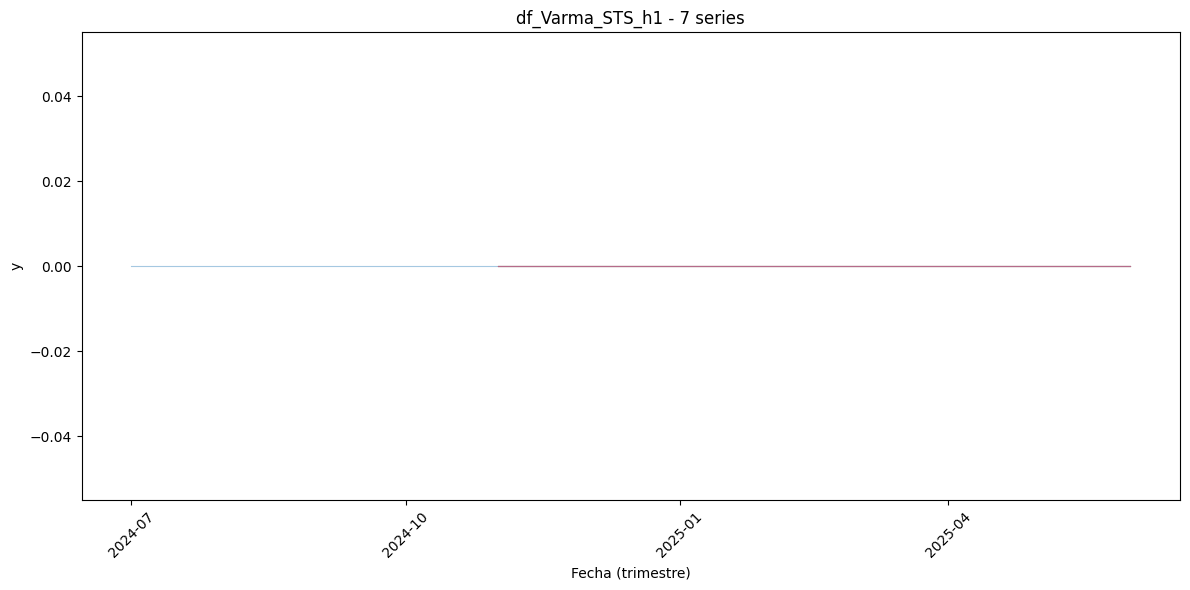

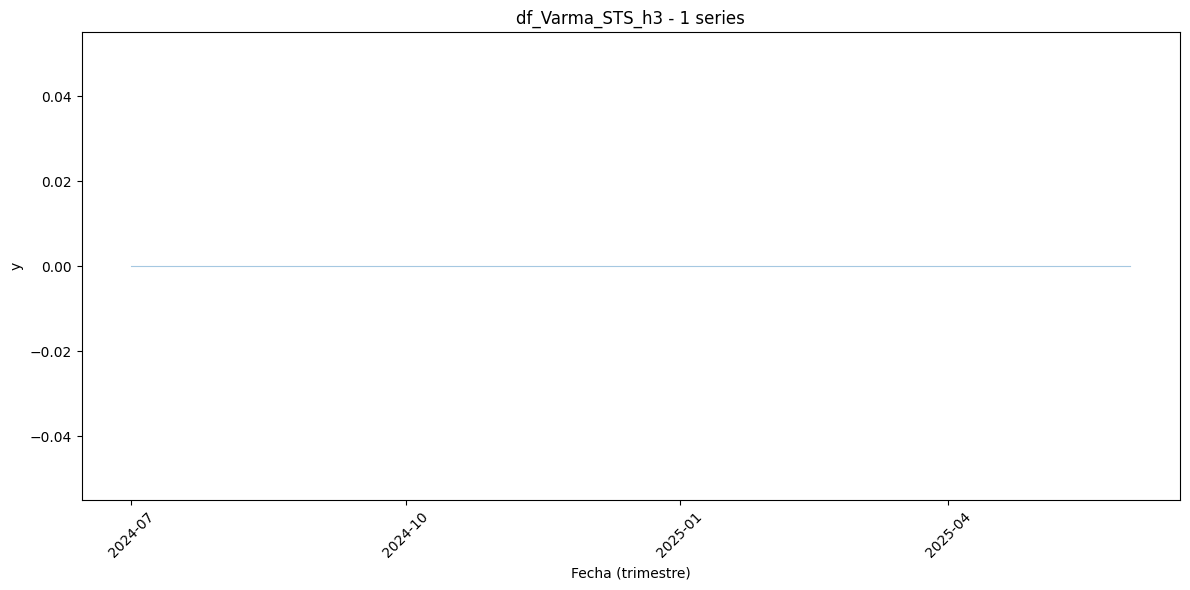

In [4]:
# Asumimos que all_horizon_ddff ya contiene únicamente los df_*_h* (Noel y Varma)
# Ejemplo: {'df_Noel_ITS_H1': df_Noel_ITS_h1, 'df_Noel_ITS_h3': df_Noel_ITS_h3, ..., 'df_Varma_LTS_h9: df_Varma_LTS_h9}

for name, df in all_horizon_ddff.items():
    # 1) Pivot a ancho: índice = fecha, columnas = unique_id
    wide = df.pivot(index = 'ds', columns = 'unique_id', values = 'y')

    # 2) Crear figura
    fig, ax = plt.subplots(figsize = (12, 6))

    # 3) Plotear cada serie con transparencia
    for col in wide.columns:
        ax.plot(wide.index, wide[col], alpha = 0.4, linewidth = 0.8)
    
    # 4) Formato trimestral en eje X: ticks en enero, abril, julio y octubre
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth = [1, 4, 7, 10]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation = 45)

    # 5) Etiquetas y Título
    ax.set_title(f'{name} - {wide.shape[1]} series')
    ax.set_xlabel('Fecha (trimestre)')
    ax.set_ylabel('y')
    plt.tight_layout()
    plt.show()


---

## Planteamiento de Pipeline

**FASE 0: Preparación del Entorno**

**Objetivo**:
Asegurar que se puede trabajar de forma reproducible, con datos cargados y limpios, y un primer cuaderno limpio para modelado.
1. **Reiniciar e instalar librerías**
      - Crear un nuevo .ipynb, instalar e importar sólo las librerías *esenciales* para esta fase.
      - Dejar apuntada la sección de pip installs necesarios.
2. **Cargar los DataFrames preprocesados**
      - Usar la función `load_all_series() para recargar, en variables globales, todos los `df_*_{SIGLA}_h{H}` y los generales.
      - Verificar que cada variable existe y tiene la forma esperada (número de series, rango de fechas).


**FASE 1: Definición de Métricas**

**Objetivo**:

Centralizar una única versión 'oficial' de cada métrica que se vaya a usar, basándose en las implementaciones de sktime siempre que sea posible.
1. **Listado de métricas prioritarias**
      - MAE, MSE, RMSE, MAPE, sMAPE, MASE, WAPE, wQL, SPEC, Theil's U, Normalized RMSE.
2. **Decidir implementaciones**
      - Para las métricas estándar (MAE, MASE, ...), importar las clases de sktime y envolverlas con un wrapper uniforme.
      - Sólo definir 'hand-rolled' SPEC, wQL y Normalized RMSE si no existen en sktime.
3. **Escribir y testear los wrappers**
      - En una celda, definir cada función y probar sobre un par de vectores sintéticos para confirmar que devuelve valores razonables.


**FASE 2: Benchmark Naïve**

**Objetivo**:

Tener siempre una linea base con la que comparar cualquier modelo nuevo.
1. **Elegir un conjunto reducido de naïve**
      - Por ejemplo: `NaiveForecaster(strategy = 'last')` (sktime), `HistoricAverage` (Nixtla), `NaiveMean` (Darts).
      - No más de 2-3 variantes para no saturar.
2. **Evaluar sólo el naïve sobre UN horizonte de prueba.
      - Elegir un ejemplo, p.ej. `df_Noel_ITS_h3`.
      - Ejecutar la rutina de splitting y evaluación (rolling-origin) sólo con esos naïve.
      - Comprobar que la función de evaluación (evaluate_model) devuelve un DataFrame 'largo' con folds y pasos.
3. Analizar resultados.
      - Calcular métricas globales y paso-a-paso para el naïve y verificar que todo tiene sentido (ej. MAE creciente con el paso, etc.).


**FASE 3: Definición del Split & Backtesting**

**Objetivo**:

Fijar la lógica de corte train/val/test y folds de validación interna para cualquer modelo que venga.
1. **Revisar y fijar `sktime_splits()`**
      - Asegurar que `initial_window = n_periods - H`, `fh = [1...H]`, `step_length = 1` funcionan en todos los casos.
      - Testear sobre 2-3 dataframes de horizonte distintos (h1, h6, h12)
2. **Documentar en Markdown**
      - Pequeña explicación de por qué esta estrategia y qué devuelve cada objeto.


**FASE 4: Rutina de Evaluación Genérica por Modelo**

**Objetivo**:

Tener una función `evaluate_model(...)` fiable que, dado un modelo un df_h, devuelva un DataFrame con métricas por fold y paso.
1. **Ajustar `evaluate_model()`**
      - Integrar los wrappers de métricas de la Fase 1.
      - Añadir un simple `print()` loggeando el estado de `train.shape` / `val.shape` para confirmar rolling-origin.
2. **Provar con el naïve**
      - Ejecutar `evaluate_model('Naive (sktime)', naïve_model, df_ejemplo, H, metrics)`.
      - Verificar qué salida es correcta y ágil.


**FASE 5: Incorporar el primer modelo 'real'**

**Objetivo**:

Añadir de uno en uno y sobre el mismo ejemplo una familia de modelos.
1. **Croston clásico (statsforecast)**
      - Definir la instancia con parámetros por defecto.
      - Ejecutar `evaluate_model('CrostonClassic', model, df_ejemplo, H, metrics)`.
      - Comparar con el naïve y analizar.
2. **Iterar variantes Croston (SBA, SBJ, TSB y ADIDA)**
      - Una a una, corridas independientes.
      - Añadir resultados al DataFrame global de resultados.


**FASE 6: Escalar a más horizontes y tipos de demanda**

**Objetivo**:

Validar que el pipeline no se rompe cuando cambiamos df_h o H.
1. **Loop controlado**
      - Para cada modelo Croston probado, ejecutar sobre un segundo horizonte (p.ej. h6).
      - Guardar y verificar.
2. **Primeros gráficos de comparación**
      - Tabla global de métricas promedio por horizonte, por modelo.


**FASE 7: Iteración con nuevos modelos**

**Objetivo**:

Ir añadiendo familias: ARIMA → Holt-Winters → ML → DL, siempre uno a uno.
1. **Definir ARIMA (sktime o statsforecast)**
      - Puesta en marcha y evaluación idéntica.
2. **Holt-Winters (AutoETS)**
3. **Un modelo ML sencillo (p.ej. RandomForestRegressor)**
4. **Y así sucesivamente...**

Para cada uno:
 - Crear la instancia con parámetros por defecto.
 - Evaluar sobre un horizonte y un tipo de serie (ej. Intermittent h3).
 - Añadir resultados, comparar y decidir si seguir avanzando.

---

### FASE 1: Definición de Métricas

**Objetivo**:

Centralizar una única versión 'oficial' de cada métrica que se vaya a usar, basándose en las implementaciones de sktime siempre que sea posible.
1. **Listado de métricas prioritarias**
      - MAE, MSE, RMSE, MAPE, sMAPE, MASE, WAPE, wQL, SPEC, Theil's U, Normalized RMSE.
2. **Decidir implementaciones**
      - Para las métricas estándar (MAE, MASE, ...), importar las clases de sktime y envolverlas con un wrapper uniforme.
      - Sólo definir 'hand-rolled' SPEC, wQL y Normalized RMSE si no existen en sktime.
3. **Escribir y testear los wrappers**
      - En una celda, definir cada función y probar sobre un par de vectores sintéticos para confirmar que devuelve valores razonables.

Para garantizar coherencia y reproducibilidad, se utilizan **siempre** las implementaciones de métricas de **sktime** para las medidas estándar, y solo se implementan 'a mano' aquellas que **no** existen en esa librería.

In [20]:
# ===============================================================
# 1. MÉTRICAS DE FORECASTING (FIX MSLE/RMSLE)
# ===============================================================
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error
)

def safe_msle(y_true, y_pred):
    yt = np.clip(y_true, 0, None)
    yp = np.clip(y_pred, 0, None)
    return mean_squared_log_error(yt, yp)

def safe_rmsle(y_true, y_pred):
    return np.sqrt(safe_msle(y_true, y_pred))

def mase_manual(y_true, y_pred, y_train, m=1):
    n = len(y_train)
    d = np.sum(np.abs(y_train[m:] - y_train[:-m])) / (n - m)
    return np.mean(np.abs(y_true - y_pred)) / d

def WAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def wQL(y_true, y_pred, quantile=0.5):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    err = y_pred - y_true
    pos = np.sum(np.where(err > 0, err, 0))
    neg = np.sum(np.where(err < 0, -err, 0))
    return 2 * ((1 - quantile) * pos + quantile * neg) / np.sum(y_true)

def SPEC(y_true, y_pred, stock_level=1):
    err  = np.array(y_pred) - np.array(y_true)
    cost = np.where(err > 0, err, -err * stock_level)
    return cost.mean()

def TheilsU(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    num = np.sum((y_pred - y_true)**2)
    den = np.sum((y_true[1:] - y_true[:-1])**2)
    return np.sqrt(num / den)

def NormRMSE(y_true, y_pred, norm='mean'):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    y = np.array(y_true)
    if norm == 'mean':
        return rmse_val / np.mean(y)
    if norm == 'range':
        return rmse_val / (y.max() - y.min())
    if norm == 'iqr':
        return rmse_val / (np.percentile(y, 75) - np.percentile(y, 25))
    raise ValueError("NormRMSE: norm debe ser 'mean','range' o 'iqr'.")

metrics = {
    'MAE':      mean_absolute_error,
    'MSE':      mean_squared_error,
    'RMSE':     lambda yt,yp: np.sqrt(mean_squared_error(yt,yp)),
    'MSLE':     safe_msle,
    'RMSLE':    safe_rmsle,
    'MAPE':     lambda yt,yp: np.mean(np.abs((yt-yp)/np.where(yt==0, np.nan, yt)))*100,
    'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,
    'MASE':     mase_manual,
    'WAPE':     WAPE,
    'wQL':      wQL,
    'SPEC':     SPEC,
    'TheilU':   TheilsU,
    'NormRMSE': NormRMSE,
}

In [21]:
# ===============================================================
# 2. SPLITTING & BACKTESTING
# ===============================================================
import pandas as pd
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter

def sktime_splits(df_group: pd.DataFrame, horizon: int,
                  id_col: str='unique_id', ds_col: str='ds', y_col: str='y'):
    y = df_group.set_index([id_col, ds_col])[y_col]
    y_panel = y.unstack(level=id_col)
    y_train_val, y_test = temporal_train_test_split(y_panel, test_size=horizon)
    n = len(y_train_val)
    splitter = ExpandingWindowSplitter(
        initial_window = n - horizon,
        fh             = list(range(1, horizon+1)),
        step_length    = 1
    )
    folds = []
    for tr_idx, val_idx in splitter.split(y_train_val):
        folds.append((y_train_val.iloc[tr_idx], y_train_val.iloc[val_idx]))
    return y_train_val, y_test, folds

In [28]:
# ===============================================================
# 3. FUNCION evaluate_model (FIX PeriodIndex conversion)
# ===============================================================
from copy import deepcopy
from sktime.forecasting.base import ForecastingHorizon, BaseForecaster

def evaluate_model(name: str,
                   model,
                   df_h: pd.DataFrame,
                   horizon: int,
                   metrics: dict) -> pd.DataFrame:
    y_trval, y_test, cv_folds = sktime_splits(df_h, horizon)
    fh = ForecastingHorizon(list(range(1, horizon+1)), is_relative=True)
    records = []

    for fold, (y_tr, y_val) in enumerate(cv_folds):
        print(f"[{name:25s} | H={horizon:2d} | fold={fold:2d}] "
              f" train={y_tr.shape}  val={y_val.shape}")

        mdl = deepcopy(model)
        # 1) Forzamos que y_tr2 tenga un DatetimeIndex regular “MS”
        y_tr2 = y_tr.copy()
        
        # convierto todo a timestamps (sea Period o Datetime)
        y_tr2.index = pd.PeriodIndex(y_tr2.index, freq='M')

        # relleno huecos
        y_tr2 = y_tr2.fillna(0)

        # 2) Ajusto y predigo
        mdl.fit(y_tr2)
        y_pred = mdl.predict(fh)  # ahora sí debería funcionar

        for step in range(1, horizon+1):
            true = y_val.iloc[step-1].values
            pred = y_pred.iloc[step-1].values
            base = dict(model=name, horizon=horizon, fold=fold, step=step)
            for m_name, func in metrics.items():
                if m_name == 'MASE':
                    base[m_name] = func(true, pred, y_tr.values.flatten())
                else:
                    base[m_name] = func(true, pred)
            records.append(base)

    return pd.DataFrame.from_records(records)

In [29]:
# ===============================================================
# 4. DICT de modelos “naïve” (sktime, panel multiserie)
# ===============================================================
from sktime.forecasting.naive import NaiveForecaster

models_naive = {
    "Naive last":      NaiveForecaster(strategy='last',  sp=1),
    "Naive mean":      NaiveForecaster(strategy='mean',  sp=1),
    "Naive drift":     NaiveForecaster(strategy='drift', sp=1),
    "Seasonal naive":  NaiveForecaster(strategy='last',  sp=12),
}

In [31]:
# ===============================================================
# 5. EJEMPLO: df_Noel_ITS_h3, H=3
# ===============================================================
df_test  = df_Noel_ITS_h3   # tu DataFrame multiserie
horizon  = 3

all_naive = []
for name, mdl in models_naive.items():
    print(f"\n▶ Evaluando {name} en df_Noel_ITS_h3 (H={horizon})")
    res = evaluate_model(name, mdl, df_test, horizon, metrics)
    res['group'] = 'naïve'
    all_naive.append(res)

df_naive_all      = pd.concat(all_naive, ignore_index=True)
metric_cols = list(metrics.keys())

df_naive_global = (
    df_naive_all
    .groupby(['model','horizon'])[metric_cols]
    .mean()
    .reset_index()
)

df_naive_stepwise = (
    df_naive_all
      .pivot_table(index=['model','horizon','fold'],
                   columns='step',
                   values=list(metrics.keys()))
      .reset_index()
)

print("\n— Métricas globales —")
display(df_naive_global)
print("\n— Métricas stepwise —")
display(df_naive_stepwise)


▶ Evaluando Naive last en df_Noel_ITS_h3 (H=3)
[Naive last                | H= 3 | fold= 0]  train=(70, 185)  val=(3, 185)


C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,
C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,
C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,



▶ Evaluando Naive mean en df_Noel_ITS_h3 (H=3)
[Naive mean                | H= 3 | fold= 0]  train=(70, 185)  val=(3, 185)

▶ Evaluando Naive drift en df_Noel_ITS_h3 (H=3)
[Naive drift               | H= 3 | fold= 0]  train=(70, 185)  val=(3, 185)


C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,
C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,
C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,



▶ Evaluando Seasonal naive en df_Noel_ITS_h3 (H=3)
[Seasonal naive            | H= 3 | fold= 0]  train=(70, 185)  val=(3, 185)

— Métricas globales —


C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,
C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,
C:\Users\AlejandroLaderasImpe\AppData\Local\Temp\ipykernel_23432\1479070481.py:64: RuntimeWarning: invalid value encountered in divide
  'sMAPE':    lambda yt,yp: np.mean(2*np.abs(yt-yp)/(np.abs(yt)+np.abs(yp)))*100,


,model,horizon,MAE,MSE,RMSE,MSLE,RMSLE,MAPE,sMAPE,MASE,WAPE,wQL,SPEC,TheilU,NormRMSE
0,Naive drift,3,3907.232796,2.620237e+08,16186.399989,18.649711,4.304371,NaN,NaN,NaN,301.085934,3.010859,3907.232796,2.230420,12.484382
1,Naive last,3,3816.135023,2.489389e+08,15774.414397,18.583938,4.296573,NaN,NaN,NaN,293.313652,2.933137,3816.135023,2.169325,12.131152
2,Naive mean,3,3820.260119,8.074197e+07,8960.111584,38.106689,6.172588,NaN,185.147157,NaN,290.747503,2.907475,3820.260119,1.218158,6.786469
3,Seasonal naive,3,1177.055544,2.145902e+07,4196.719924,11.219849,3.336212,NaN,NaN,NaN,98.891520,0.988915,1177.055544,0.643844,3.667605



— Métricas stepwise —


model horizon fold          MAE                            \
step                                         1            2            3   
0        Naive drift       3    0  4209.813722  3634.108727  3877.775938   
1         Naive last       3    0  4167.983856  3537.885265  3742.535948   
2         Naive mean       3    0  4183.580828  3733.913543  3543.285985   
3     Seasonal naive       3    0   932.122019   900.319919  1698.724694   

               MSE                                   MSLE  ...    TheilU  \
step             1             2             3          1  ...         3   
0     2.673167e+08  2.634770e+08  2.552774e+08  21.928707  ...  2.960292   
1     2.607178e+08  2.504355e+08  2.356634e+08  21.888144  ...  2.844294   
2     9.390153e+07  8.338251e+07  6.494188e+07  37.153462  ...  1.493107   
3     7.245815e+06  8.593340e+06  4.853790e+07  10.088491  ...  1.290830   

            WAPE                               sMAPE                          \
step           1           2           3           1           2           3   
0     248.119753  237.790079  417.347970         NaN         NaN         NaN   
1     245.654367  231.493904  402.792685         NaN         NaN         NaN   
2     246.573628  244.320593  381.348288  185.161428  184.178493  186.101549   
3      54.937795   58.910495  182.826268         NaN         NaN         NaN   

           wQL                      
step         1         2         3  
0     2.481198  2.377901  4.173480  
1     2.456544  2.314939  4.027927  
2     2.465736  2.443206  3.813483  
3     0.549378  0.589105  1.828263  

[4 rows x 36 columns]

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import pandas as pd
from copy import deepcopy
from sktime.split import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon


In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
import pandas as pd
import numpy as np
from copy import deepcopy
from sktime.split import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon, BaseForecaster

def plot_naive_comparison(df_h, models_naive, horizon, sample_size=5, history=12):
    """
    Para cada unique_id (hasta sample_size aleatorio):
     - Traza los últimos `history` puntos de histórico,
     - Traza los `horizon` puntos reales de test,
     - Traza en la misma figura los pronósticos 'last', 'mean' y 'drift'.
    Soporta sktime NaiveForecaster y StatsForecast univariante.
    """
    # 1) Pivot a ancho y split
    y = df_h.set_index(['unique_id','ds'])['y'].unstack('unique_id')
    y_train_val, y_test = temporal_train_test_split(y, test_size=horizon)

    # 2) Sample de series
    uids = list(y.columns)
    if sample_size is not None and sample_size < len(uids):
        uids = random.sample(uids, sample_size)

    fh = ForecastingHorizon(list(range(1, horizon+1)), is_relative=True)

    for uid in uids:
        # Histórico + reales
        hist = y_train_val[uid].copy()
        hist.index = pd.to_datetime(hist.index)  # elimina PeriodIndex/freq
        hist = hist.fillna(0)

        actual = y_test[uid].copy()
        actual.index = pd.to_datetime(actual.index)

        # Plot base
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(
            hist.index[-history:], hist.values[-history:],
            label='History', linewidth=2
        )
        ax.plot(
            actual.index, actual.values,
            label='Actual', linewidth=2
        )

        # Ajustamos un panel_train *sin* freq impuesto
        panel_train = y_train_val.copy()
        panel_train.index = pd.to_datetime(panel_train.index)
        panel_train = panel_train.fillna(0)

        # 3) Para cada modelo naïve
        for name, model in models_naive.items():
            mdl = deepcopy(model)
            if isinstance(mdl, BaseForecaster):
                # --- sktime panel-wide ---
                mdl.fit(panel_train)
                y_pred = mdl.predict(fh)      # DataFrame H×n_series
                fc = y_pred[uid].values
            else:
                # --- univariante StatsForecast ---
                series_tr = panel_train[uid].values.astype(float)
                mdl.fit(series_tr)
                p = mdl.predict(horizon)      # array-like H
                fc = np.asarray(p).flatten()

            # fechas de forecast = mismas que actual.index
            ax.plot(
                actual.index, fc,
                '--o', label=name, linewidth=2
            )

        # Formato trimestral eje X
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)

        ax.set_title(f'Serie {uid}')
        ax.legend(loc='upper left')
        plt.tight_layout()
        plt.show()


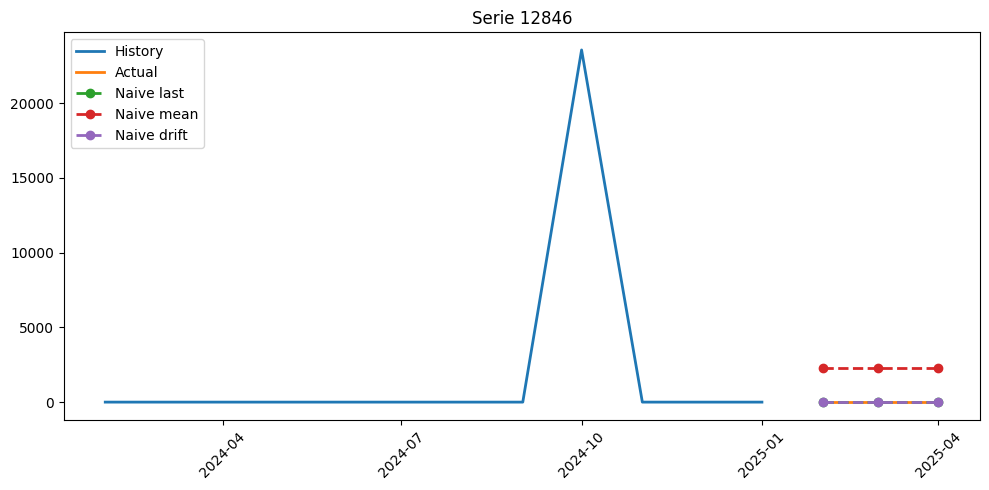

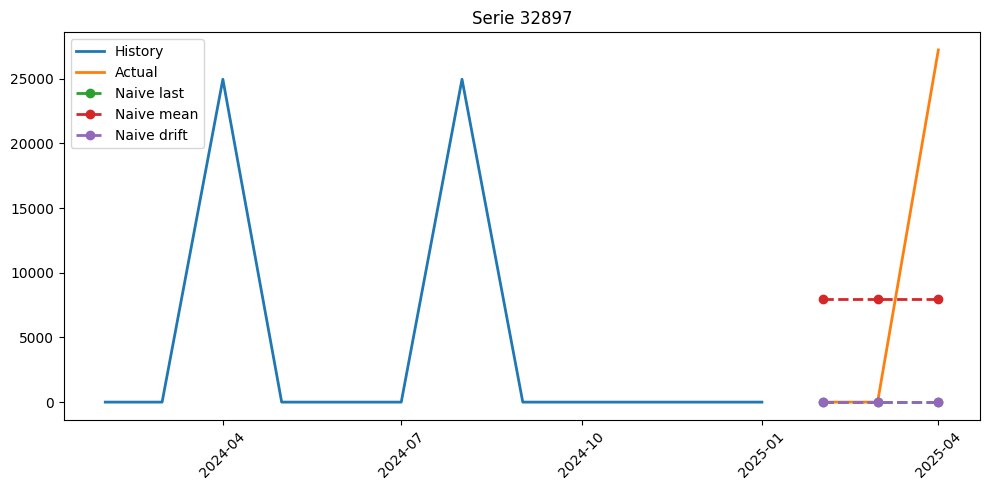

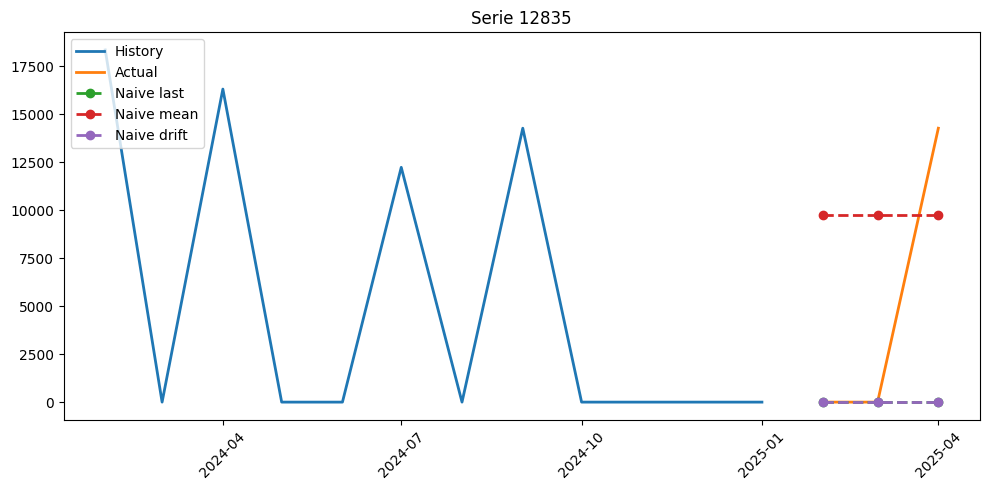

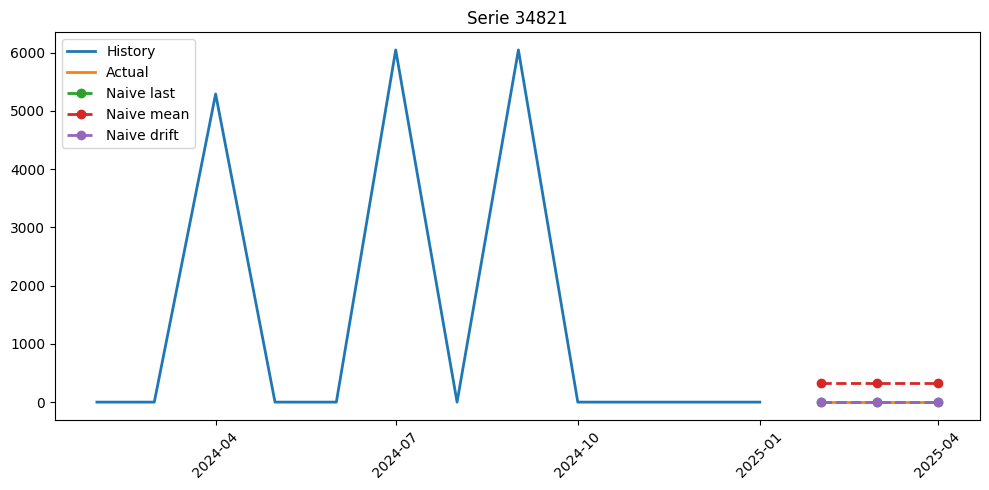

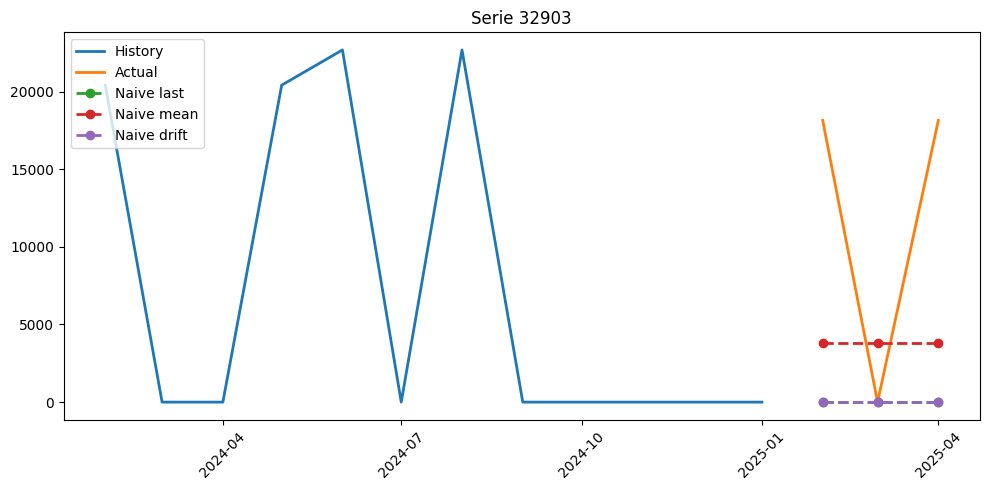

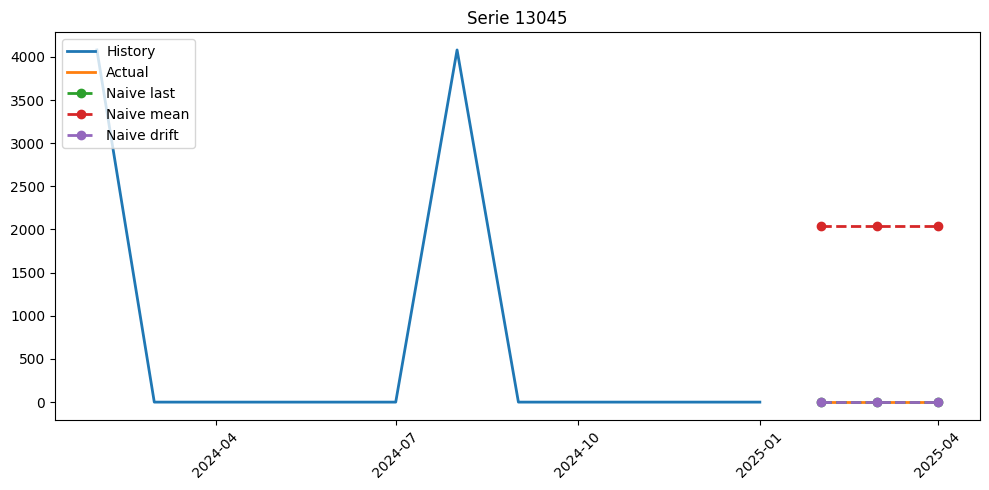

In [51]:
plot_naive_comparison(
    df_h         = df_Noel_ITS_h12,
    models_naive = {
        "Naive last":  NaiveForecaster(strategy='last',  sp=1),
        "Naive mean":  NaiveForecaster(strategy='mean',  sp=1),
        "Naive drift": NaiveForecaster(strategy='drift', sp=1),
    },
    horizon     = 3,
    sample_size = 6,   # cuántas series graficar
    history     = 12   # meses de histórico
)
